# Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

## Problem Statement

#### In this lab, we're diving into the realm of deep learning by exploring a common practice among engineers: fine-tuning existing models for specific tasks. Our goal is to classify images of dogs and cats using two approaches. First, we'll train a custom Convolutional Neural Network (CNN) and then we'll fine-tune the VGG16 model, which comes pre-trained on ImageNet. Our journey starts with obtaining the Dogs vs Cats dataset and delving into its nuances through thorough exploratory data analysis (EDA). Then, armed with insights, we'll design and train our models, ensuring we validate their performance to guard against overfitting.


#### With models in hand, we'll evaluate their effectiveness using various metrics, dissecting where they succeed and where they stumble. Finally, we'll draw conclusions, shedding light on our experiment's outcomes and suggesting avenues for future improvement. Through clear code, insightful analysis, and structured presentation, we aim to unravel the mysteries of image classification with deep learning.

## Importing libraries and notebook config

In [37]:
import os, random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import numpy as np
import pandas as pd

# Data preprocessing package/modules
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split

# Deep learnign package/modules
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# VGG16 related packanges
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Model insights
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve
from tensorflow.keras.models import load_model

# Ignore package/modules warnings
import warnings
import logging
warnings.filterwarnings("ignore")
tf.get_logger().setLevel(logging.ERROR)

## Loading Data and EDA

#### NOTE: Although we are loading data in both train and test folder, we will only use data from train folder as images in test folder are unlabelled. They are for exploration purpose only.

#### Creating dataframes for train and test images

In [2]:
train_df = pd.DataFrame(columns = ['path', 'name', 'width', 'height', 'label'])
test_df = pd.DataFrame(columns = ['path', 'name', 'width', 'height'])

#### Load  images from train and test directories

In [3]:
# Determining test and train data directories
train_data = './data/train/'
test_data = './data/test/'

#### Function to load images and creating a dictionary to be added to dataframe

In [4]:
def load_images(directory, test_data = False):
    img_list, images = [], []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_data = dict()
            img_data['name'] = filename.split('/')[-1]
            if not test_data:
                img_data['label'] = img_data['name'].split('.')[0]
            img_path = os.path.join(directory, filename)
            img_data['path'] = img_path
            with open(img_path, 'rb') as file:
                img = Image.open(file)
            images.append(img)
            img_data['width'] = int(img.size[0]) # Adding image width to dataframe
            img_data['height'] = int(img.size[1]) # Adding image height to dataframe

            img_list.append(img_data)
            
    return img_list, images

In [5]:
train_img_data, train_images  = load_images(train_data)
test_img_data, test_images = load_images(test_data, test_data = True)

#### Addding dictionary to dataframe

In [6]:
train_df = pd.concat([train_df, pd.DataFrame(train_img_data)], ignore_index=True)
test_df = pd.concat([test_df, pd.DataFrame(test_img_data)], ignore_index=True)

#### Displaay 5 random entries from both test and train data

In [7]:
train_df.sample(5)

,path,name,width,height,label
23093,./data/train/dog.8282.jpg,dog.8282.jpg,500,374,dog
462,./data/train/cat.10412.jpg,cat.10412.jpg,360,381,cat
4578,./data/train/cat.2869.jpg,cat.2869.jpg,499,252,cat
11378,./data/train/cat.899.jpg,cat.899.jpg,500,431,cat
16839,./data/train/dog.2653.jpg,dog.2653.jpg,500,373,dog


In [8]:
test_df.sample(5)

,path,name,width,height
4112,./data/test/2449.jpg,2449.jpg,228,189
3889,./data/test/2248.jpg,2248.jpg,480,382
7796,./data/test/5765.jpg,5765.jpg,350,294
7119,./data/test/5155.jpg,5155.jpg,374,500
11941,./data/test/9496.jpg,9496.jpg,237,421


#### Function to display 4 random images from test or train data

In [9]:
def display_images(image_paths):
    plt.figure(figsize=(12, 8))
    # Choose num_images random image paths
    random_images = random.sample(image_paths, min(4, len(image_paths)))
    # Display random images
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        plt.subplot(2, 2, i+1)  # Create subplots
        plt.imshow(img)
        plt.title(os.path.basename(img_path).split('.')[0])  # Display filename as title
        plt.axis('off')  # Turn off axis
    plt.show()

#### Display images from train directories

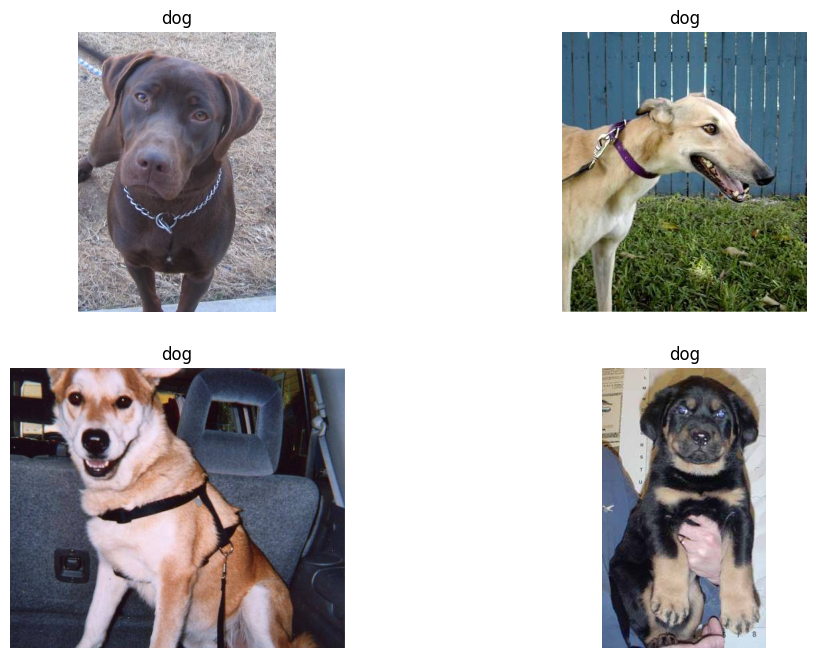

In [10]:
display_images(train_df['path'].tolist())

#### Display images from test directories

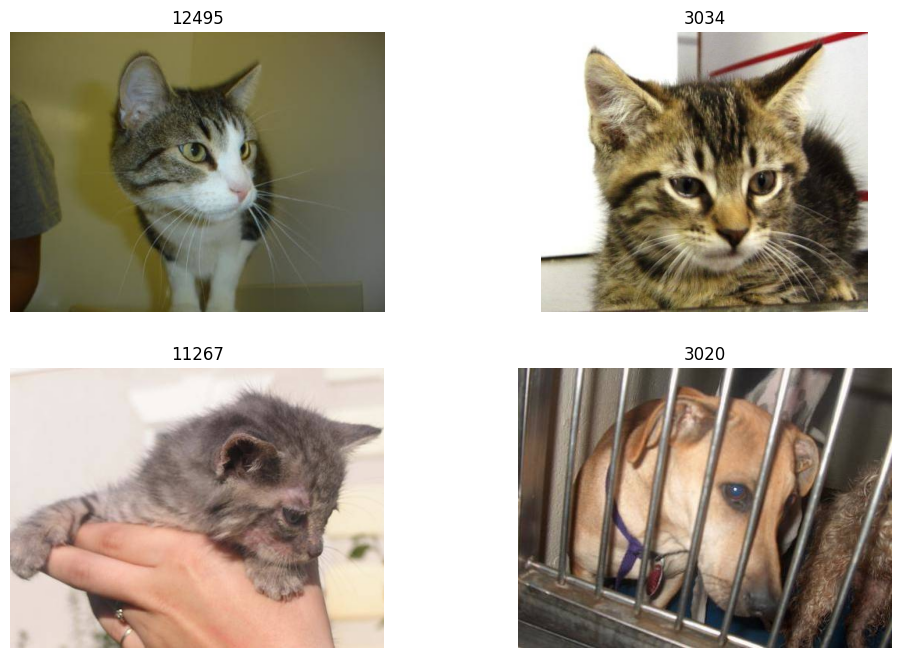

In [11]:
display_images(test_df['path'].tolist())

#### Count number of images in each category

In [12]:
cat_count_train = len([filename for filename in os.listdir(train_data) if filename.startswith('cat')])
dog_count_train = len([filename for filename in os.listdir(train_data) if filename.startswith('dog')])
cat_count_train, dog_count_train

(12500, 12500)

#### Plotting the counts

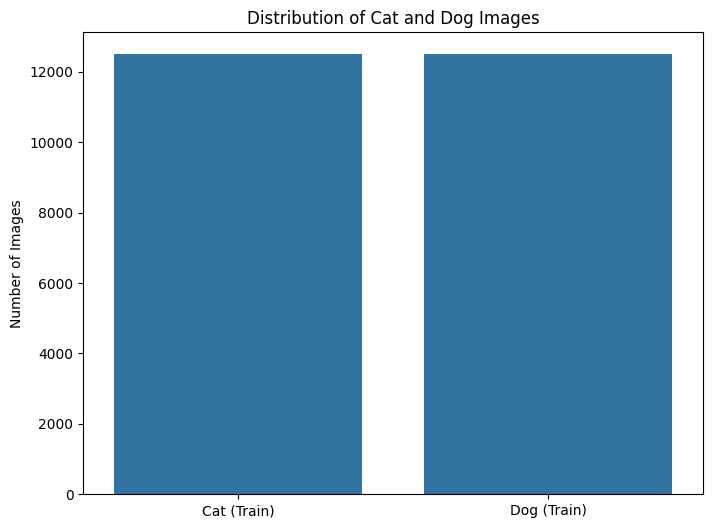

In [13]:
plt.figure(figsize=(8, 6))
sns.barplot(x=['Cat (Train)', 'Dog (Train)'],
            y=[cat_count_train, dog_count_train])
plt.title('Distribution of Cat and Dog Images')
plt.ylabel('Number of Images')
plt.show()

It can be seen from graphs and above count that the data in training set is equally distributed for both dog and cat.

#### Plotting the distributions of heights and width of images

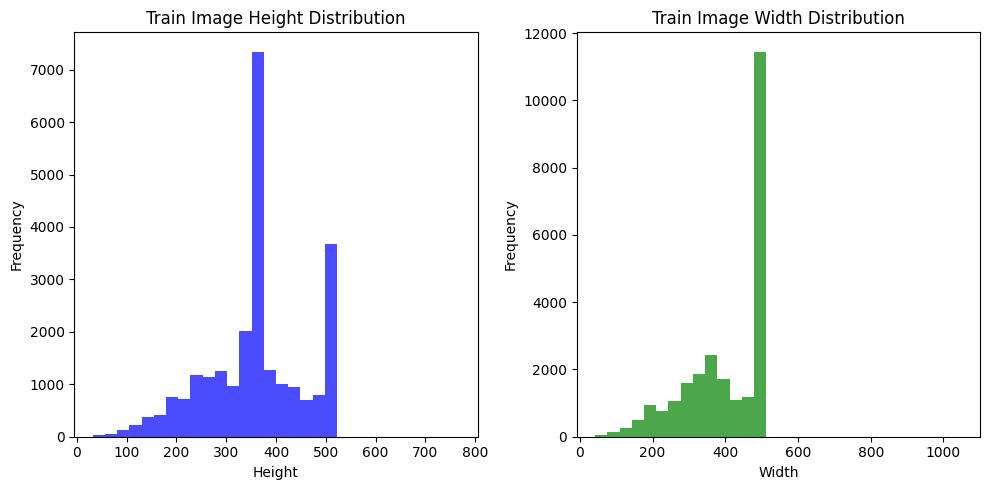

In [14]:
train_sizes = np.array(train_df[['height', 'width']])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(train_sizes[:, 0], bins=30, color='blue', alpha=0.7)
plt.title('Train Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(train_sizes[:, 1], bins=30, color='green', alpha=0.7)
plt.title('Train Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Exploring minimum and maximum height for images in given train and test data

The data displays image heights in the train dataset. It shows more images between 200-400 pixels, with fewer below 200 pixels. Most images fall within the 200-600 pixel range.

- The narrowest images are 42 pixels, and the widest reach 1050 pixels.
- The shortest images are 32 pixels, and the tallest reach 768 pixels.s.

# Preprocess data

#### Function to resize image to 32x32 pixels

We are resizing images to 32x32 pixels as VGG16 model expects images in size (32x32). Also minimum height of imgaes have in dataset is 32 pixels.

In [17]:
# Setting path for resized images
train_img_resized_path = './data/resized/train/'
test_img_resized_path = './data/resized/test/'

# Creating directories if does not exist
os.makedirs(train_img_resized_path, exist_ok=True)
os.makedirs(test_img_resized_path, exist_ok=True)

In [18]:
def resize_images(image_paths, image_names, output_folder, new_size=(32, 32)):

    resized_paths = []
    
    for index, image_path in enumerate(image_paths):
        resized_path = os.path.join(output_folder, image_names.iloc[index])
        resized_paths.append(resized_path)
        
        # Check if the resized image already exists
        if os.path.exists(resized_path):
            continue
            
        image = Image.open(image_path)
        resized_image = image.resize(new_size)
        resized_image.save(resized_path)
    
    return resized_paths

#### Adding new values and paths to the dataframe

In [19]:
train_df['path_resized'] = resize_images(train_df['path'], train_df['name'], train_img_resized_path)
train_df['height_resized'] = 32
train_df['width_resized'] = 32
train_df.head()

,path,name,width,height,label,path_resized,height_resized,width_resized
0,./data/train/cat.0.jpg,cat.0.jpg,500,374,cat,./data/resized/train/cat.0.jpg,32,32
1,./data/train/cat.1.jpg,cat.1.jpg,300,280,cat,./data/resized/train/cat.1.jpg,32,32
2,./data/train/cat.10.jpg,cat.10.jpg,489,499,cat,./data/resized/train/cat.10.jpg,32,32
3,./data/train/cat.100.jpg,cat.100.jpg,403,499,cat,./data/resized/train/cat.100.jpg,32,32
4,./data/train/cat.1000.jpg,cat.1000.jpg,150,149,cat,./data/resized/train/cat.1000.jpg,32,32


In [20]:
test_df['path_resized'] = resize_images(test_df['path'], test_df['name'], test_img_resized_path)
test_df['height_resized'] = 32
test_df['width_resized'] = 32
test_df.head()

,path,name,width,height,path_resized,height_resized,width_resized
0,./data/test/1.jpg,1.jpg,381,499,./data/resized/test/1.jpg,32,32
1,./data/test/10.jpg,10.jpg,500,374,./data/resized/test/10.jpg,32,32
2,./data/test/100.jpg,100.jpg,499,343,./data/resized/test/100.jpg,32,32
3,./data/test/1000.jpg,1000.jpg,288,499,./data/resized/test/1000.jpg,32,32
4,./data/test/10000.jpg,10000.jpg,467,499,./data/resized/test/10000.jpg,32,32


#### Encoding labels for model training

> REASON: Models only understand numerical data not test

In [21]:
train_df['label_bin'] = train_df['label'].apply(lambda x: 0 if x.lower() == 'cat' else 1)

#### Converting image data to numpy array

We are creating function that uses out preprocessed images and convert them to a numpy array saving values of images in array. We will also normalize pixel values by dividing by 255 as pixel values are stored from 0-255. 

In [22]:
def image_to_list(df):
    X = []
    for index, row in df.iterrows():
        img = load_img(row['path_resized'])
        img_array = img_to_array(img)
        
        # Normalize pixel values
        img_array /= 255.0
        
        X.append(img_array)
        
    return np.array(X)

#### Determining dependent and independent variables

In [23]:
X = image_to_list(train_df)
Y = np.array(train_df['label_bin'])

#### Split data into train and test sets

We will split data in train, validation and testing samples in ration 70:15:15 resp. We will train model with training dataset, use validation samples to evaluate model perfomrmance and test data to test model.

In [24]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, stratify= Y, test_size=0.3)
X_test, X_val, Y_test, Y_val = train_test_split(X, Y, stratify = Y_temp, test_size=0.5)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape

((17500, 32, 32, 3),
 (17500,),
 (12500, 32, 32, 3),
 (12500,),
 (12500, 32, 32, 3),
 (12500,))

> NOTE: We are creating out test samples from out training dataset only as out test data does not have labels hence can not be used to get model performance

# Modelling

#### Defining and compiling the CNN model

In [25]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### Define the ModelCheckpoint callback

In [26]:
cnn_checkpoint = ModelCheckpoint(
    "./best_model_cnn.h5", 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max'
)

#### Train the model with callbacks

In [27]:
cnn_history = cnn_model.fit(
    X_train, 
    Y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, Y_val), 
    callbacks=[cnn_checkpoint]
)

Epoch 1/20
546/547 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.5902
Epoch 1: val_accuracy improved from -inf to 0.64240, saving model to .\best_model_cnn.h5
547/547 [==============================] - 9s 14ms/step - loss: 0.6605 - accuracy: 0.5903 - val_loss: 0.6379 - val_accuracy: 0.6424
Epoch 2/20
543/547 [============================>.] - ETA: 0s - loss: 0.5747 - accuracy: 0.7034
Epoch 2: val_accuracy improved from 0.64240 to 0.72496, saving model to .\best_model_cnn.h5
547/547 [==============================] - 7s 13ms/step - loss: 0.5750 - accuracy: 0.7031 - val_loss: 0.5520 - val_accuracy: 0.7250
Epoch 3/20
543/547 [============================>.] - ETA: 0s - loss: 0.5209 - accuracy: 0.7385
Epoch 3: val_accuracy improved from 0.72496 to 0.74160, saving model to .\best_model_cnn.h5
547/547 [==============================] - 7s 13ms/step - loss: 0.5213 - accuracy: 0.7381 - val_loss: 0.5147 - val_accuracy: 0.7416
Epoch 4/20
542/547 [=======================

#### Plot training and validation accuracy adn loss for CNN model

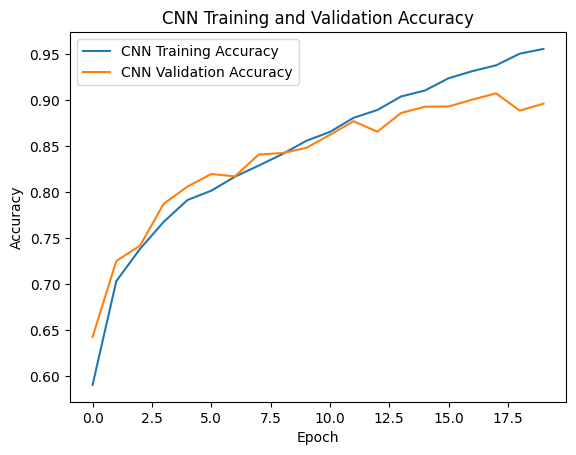

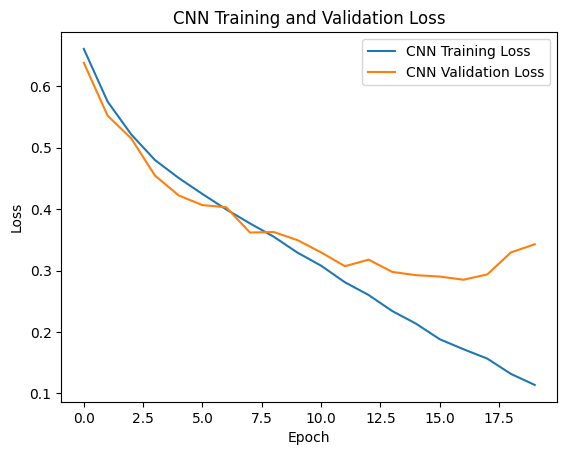

In [28]:
# Plot accuracy for CNN model
plt.plot(cnn_history.history['accuracy'], label='CNN Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss for CNN model
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.show()

The graphs illustrate the training and validation accuracy of a convolutional neural network (CNN) model. The training accuracy consistently increases to around 0.95, indicating good performance on training data. However, the validation accuracy fluctuates around 0.80, suggesting possible overfitting. 

#### Define adn compile VGG16 model with fine-tuning

In [29]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg16_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

58889256/58889256 [==============================] - 1s 0us/step


#### Creating VGG model check points

In [30]:
vgg_checkpoint = ModelCheckpoint(
    "best_model_VGG16.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

#### Retrining VGG16 model

In [32]:
vgg16_history = vgg16_model.fit(
    X_train, 
    Y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[vgg_checkpoint]
)

Epoch 1/20
547/547 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.6943
Epoch 1: val_accuracy improved from -inf to 0.70552, saving model to best_model_VGG16.h5
547/547 [==============================] - 82s 148ms/step - loss: 0.5732 - accuracy: 0.6943 - val_loss: 0.5601 - val_accuracy: 0.7055
Epoch 2/20
547/547 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7236
Epoch 2: val_accuracy improved from 0.70552 to 0.72496, saving model to best_model_VGG16.h5
547/547 [==============================] - 77s 141ms/step - loss: 0.5416 - accuracy: 0.7236 - val_loss: 0.5350 - val_accuracy: 0.7250
Epoch 3/20
547/547 [==============================] - ETA: 0s - loss: 0.5276 - accuracy: 0.7297
Epoch 3: val_accuracy improved from 0.72496 to 0.74160, saving model to best_model_VGG16.h5
547/547 [==============================] - 77s 141ms/step - loss: 0.5276 - accuracy: 0.7297 - val_loss: 0.5098 - val_accuracy: 0.7416
Epoch 4/20
547/547 [=================

#### Plot training and validation accuracy and loss for VGG16 model

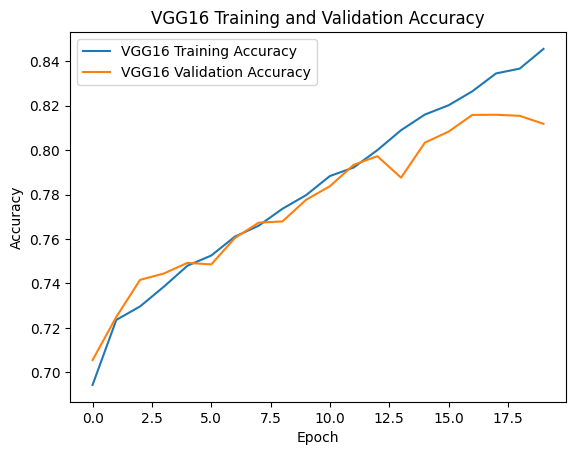

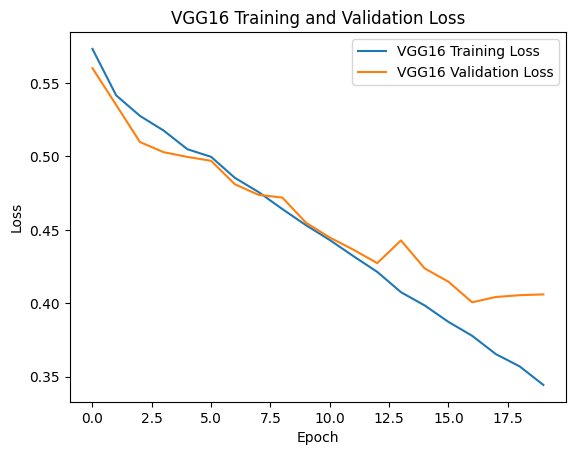

In [33]:
# Plot accuracy for VGG16 model
plt.plot(vgg16_history.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(vgg16_history.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot loss for VGG16 model
plt.plot(vgg16_history.history['loss'], label='VGG16 Training Loss')
plt.plot(vgg16_history.history['val_loss'], label='VGG16 Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VGG16 Training and Validation Loss')
plt.legend()
plt.show()

The graphs depict the training and validation performance of a VGG16 model across epochs. Training accuracy improves from 0.7 to 0.84, while validation accuracy rises from 0.7 to 0.82. Both training and validation loss decrease, indicating good model fitting. The close proximity of validation accuracy to training accuracy suggests minimal overfitting. Final accuracy estimates are approximately 84% for training and 82% for validation. 

# Model Evaluations

#### Load the best versions of the models

In [39]:
cnn_best_model = load_model("./best_model_cnn.h5")
vgg16_best_model = load_model("./best_model_VGG16.h5")

#### Predictions

In [46]:
Y_pred_cnn = cnn_best_model.predict(X_test).round()
Y_pred_vgg16 = vgg16_best_model.predict(X_test).round()

391/391 [==============================] - 34s 87ms/step


#### Evaluate the models on the test data

In [47]:
cnn_scores = cnn_best_model.evaluate(X_test, Y_test, verbose=0)
vgg16_scores = vgg16_best_model.evaluate(X_test, Y_test, verbose=0)

#### Classification report

In [57]:
cnn_report = classification_report(Y_test, Y_pred_cnn, output_dict=True)
vgg16_report = classification_report(Y_test, Y_pred_vgg16, output_dict=True)

#### Create the model summary dataframe

In [49]:
model_summary = pd.DataFrame({
    'Model': ['CNN', 'VGG16'],
    'Accuracy': [cnn_scores[1], vgg16_scores[1]],
    'Precision': [cnn_report['1']['precision'], vgg16_report['1']['precision']],
    'Recall': [cnn_report['1']['recall'], vgg16_report['1']['recall']],
    'F1-score': [cnn_report['1']['f1-score'], vgg16_report['1']['f1-score']]
})

In [52]:
model_summary

,Model,Accuracy,Precision,Recall,F1-score
0,CNN,0.90000,0.915535,0.881940,0.898424
1,VGG16,0.81904,0.810350,0.834397,0.822198


#### Plot confusion matrices

In [53]:
cnn_conf_matrix = confusion_matrix(Y_test, Y_pred_cnn)
vgg16_conf_matrix = confusion_matrix(Y_test, Y_pred_vgg16)

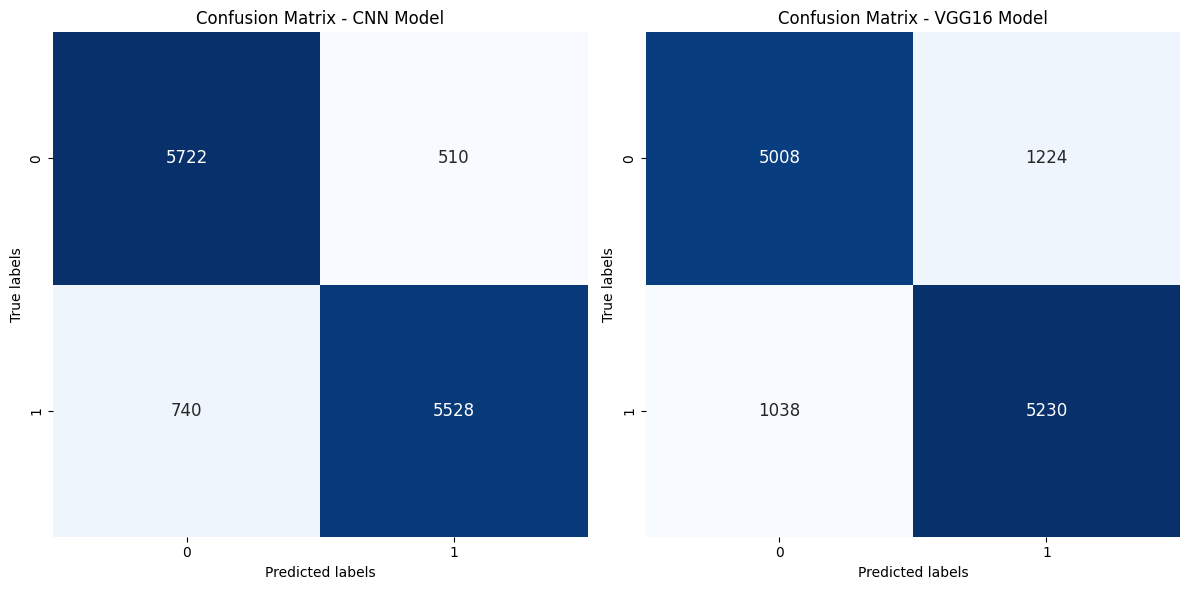

In [54]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Confusion Matrix - CNN Model")
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize":12})
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

plt.subplot(1, 2, 2)
plt.title("Confusion Matrix - VGG16 Model")
sns.heatmap(vgg16_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"fontsize":12})
plt.xlabel("Predicted labels")
plt.ylabel("True labels")

plt.tight_layout()
plt.show()

#### Compute precision-recall curve

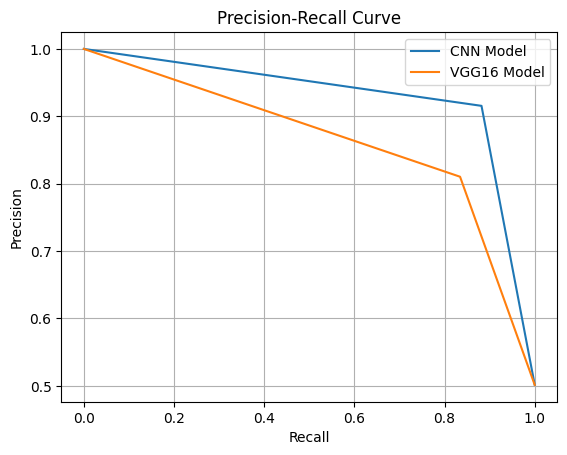

In [58]:
cnn_precision, cnn_recall, _ = precision_recall_curve(Y_test, Y_pred_cnn)
vgg16_precision, vgg16_recall, _ = precision_recall_curve(Y_test, Y_pred_vgg16)

# Plot precision-recall curve
plt.plot(cnn_recall, cnn_precision, label='CNN Model')
plt.plot(vgg16_recall, vgg16_precision, label='VGG16 Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Conclusions

#### Insights based on above evaluations of best moodels

The comparison provided is between two image classification models, CNN (Convolutional Neural Network) and VGG16. The table summarizes various metrics for each model:
- 
Accuracy: CNN achieves 90%, while VGG16 achieves 81.9
- .
Precision: CNN has 91.6%, VGG16 has 8
- %.
Recall: CNN scores 88.2%, VGG16 scores 83
- 4%.
F1-Score: CNN achieves 89.8%, VGG16 achieves 8asets.